In [44]:
import django
import os
import sys
import shutil

path='../../'

source_file_path = f'{path}.env'

destination_file_path = '.'

shutil.copy(source_file_path, destination_file_path)

from dotenv import dotenv_values

_config = dotenv_values(".env")
_username = _config["username"]

session_file_path = f'{path}{_username}.session'

# shutil.copy('Farnoooooood.session', destination_file_path)


project_path = path  # Adjust this to your actual project path
sys.path.append(project_path)
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'oogway.settings')
django.setup()


In [45]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [46]:
from django.db.models import Sum
from django.db.models.functions import TruncMonth
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async
# Django ORM equivalent
results = await sync_to_async(
        lambda: list(
            Predict.objects
            .select_related('post__channel')
            .annotate(month=TruncMonth('date'))
            .values('post__channel__name', 'month')
            .annotate(total_profit=Sum('profit'))
            .order_by('month', 'post__channel__name')
        )
    )()

for result in results:
    print(result['post__channel__name'], result['month'], result['total_profit'])

# results


FEYZIAN 2023-11-01 00:00:00+03:30 42.99122999999999
FEYZIAN 2023-12-01 00:00:00+03:30 -343.2854
FEYZIAN 2024-01-01 00:00:00+03:30 -113.16239000000004
FEYZIAN 2024-02-01 00:00:00+03:30 153.73805
FEYZIAN 2024-03-01 00:00:00+03:30 74.9756
FEYZIAN 2024-04-01 00:00:00+03:30 77.9062
FEYZIAN 2024-05-01 00:00:00+03:30 -223.99226999999996
FEYZIAN 2024-06-01 00:00:00+03:30 -97.64638
FEYZIAN 2024-07-01 00:00:00+03:30 -28.483470000000025
FEYZIAN 2024-08-01 00:00:00+03:30 -142.77534000000003
FEYZIAN 2024-09-01 00:00:00+03:30 -22.08712999999999
FEYZIAN 2024-10-01 00:00:00+03:30 -90.73062999999999
RASTAD 2024-10-01 00:00:00+03:30 -78.88213000000002
FEYZIAN 2024-11-01 00:00:00+03:30 -39.512280000000004
RASTAD 2024-11-01 00:00:00+03:30 167.63890999999995


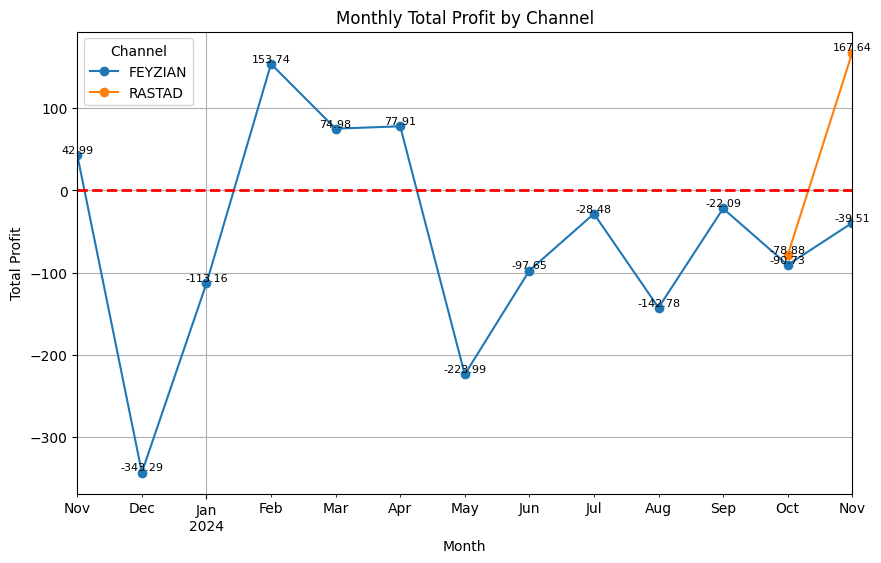

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Sample data to simulate results from Django ORM
# Assuming `results` has the fields `channel_name`, `month`, and `total_profit`


# Convert the data to a DataFrame
df = pd.DataFrame(results)

# Pivot the DataFrame to format it for plotting
pivot_df = df.pivot(index='month', columns='post__channel__name', values='total_profit')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='line', marker='o', ax=ax)

# Adding a high contrast horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
# ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Baseline (y=0)')

# Setting labels, title, and legend
plt.title('Monthly Total Profit by Channel')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.legend(title='Channel')
plt.grid()
for channel in pivot_df.columns:
    for month, value in pivot_df[channel].items():
        if pd.notnull(value):  # Only annotate non-null values
            ax.text(month, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.show()




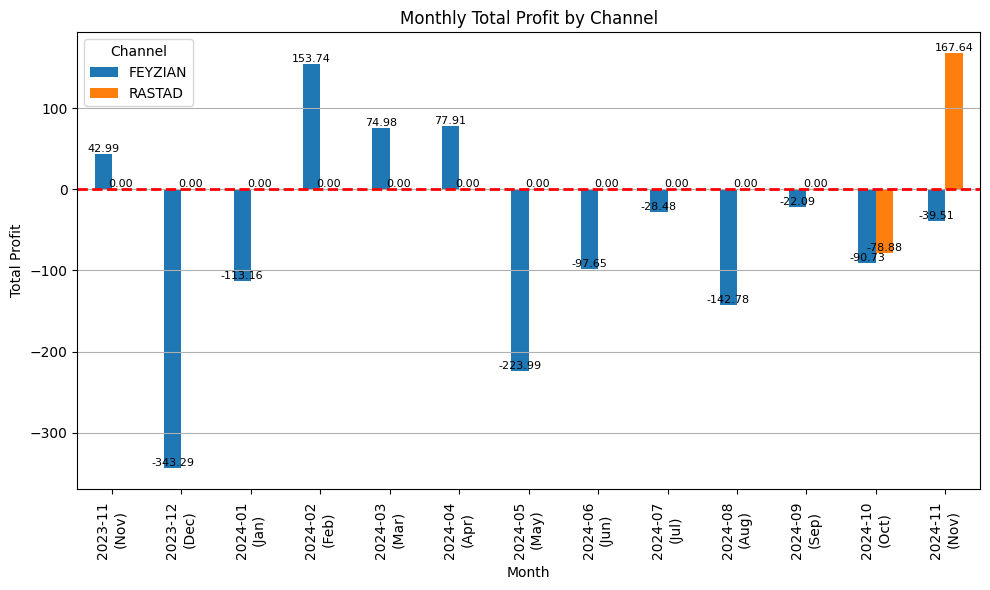

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


# Convert the data to a DataFrame
df = pd.DataFrame(results)
df['month'] = pd.to_datetime(df['month']).dt.strftime('%Y-%m \n(%b)')
# df['month'] = pd.to_datetime(df['month'])

# Sort by month to ensure proper order
df = df.sort_values(by='month')
# Pivot the DataFrame to format it for plotting
pivot_df = df.pivot(index='month', columns='post__channel__name', values='total_profit')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)

# Adding a high contrast horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Setting labels, title, and legend
plt.title('Monthly Total Profit by Channel')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.legend(title='Channel')
plt.grid(axis='y')  # Grid only for y-axis to improve readability

# Adding data labels to each bar
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Only annotate non-null values
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()


In [32]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
gross_loss = await sync_to_async(
    lambda: Predict.objects.filter(
        status__name__in=['FAILED WITH PROFIT', 'FAILED']
    ).aggregate(
        failed_profit=Sum('profit'),
        failed_count=Count('id')
    )
)()

gross_loss


{'failed_profit': -4995.282630000002, 'failed_count': 272}

In [33]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
gross_win = await sync_to_async(
    lambda: Predict.objects.filter(
        status__name__in=['SUCCESS', 'FULLTARGET']
    ).aggregate(
        win_profit=Sum('profit'),
        win_count=Count('id')
    )
)()

gross_win


{'win_profit': 4331.975200000003, 'win_count': 134}

In [34]:
from django.db.models import Sum, Count, Case, When, IntegerField, FloatField
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function
result = await sync_to_async(
    lambda: Predict.objects.filter(**{}).aggregate(
        gross_loss=Sum(
            Case(
                When(status__name__in=['FAILED WITH PROFIT', 'FAILED'], then='profit'),
                output_field=FloatField()
            )
        ),
        loss_count=Count(
            Case(
                When(status__name__in=['FAILED WITH PROFIT', 'FAILED'], then=1),
                output_field=IntegerField()
            )
        ),
        gross_profit=Sum(
            Case(
                When(status__name__in=['SUCCESS', 'FULLTARGET'], then='profit'),
                output_field=FloatField()
            )
        ),
        win_count=Count(
            Case(
                When(status__name__in=['SUCCESS', 'FULLTARGET'], then=1),
                output_field=IntegerField()
            )
        ),
        total_gross=Sum('profit', output_field=FloatField()),  # Total profit for all statuses
        total_count=Count('id', output_field=IntegerField()) 
    )
)()

gross_loss = result['gross_loss']
loss_count = result['loss_count']
gross_profit = result['gross_profit']
win_count = result['win_count']
total_count = result['total_count']
total_gross = result['total_gross']

loss_rate = loss_count/total_count
win_rate = win_count/total_count
average_loss = gross_loss/loss_count
average_win = gross_profit/win_count
expectancy = (win_rate * average_win)-(abs(loss_rate * average_loss))
profit_factor =  abs(gross_profit/gross_loss if gross_loss else 1)
payoff_ratio = abs(average_win/average_loss if average_loss else 1)

print(f'total_count: {total_count}')
print(f'total_gross: {total_gross}')
print(f'total_count: {total_count}')
print(f'gross_loss: {gross_loss}')
print(f'loss_count: {loss_count}')
print(f'gross_profit: {gross_profit}')
print(f'win_count: {win_count}')
print(f'loss_rate: {loss_rate}')
print(f'win_rate: {win_rate}')
print(f'average_loss: {average_loss}')
print(f'average_win: {average_win}')
print(f'expectancy: {expectancy}')
print(f'profit_factor: {profit_factor}')
print(f'payoff_ratio: {payoff_ratio}')


total_count: 479
total_gross: -663.3074299999994
total_count: 479
gross_loss: -4995.282630000002
loss_count: 272
gross_profit: 4331.975200000003
win_count: 134
loss_rate: 0.5678496868475992
win_rate: 0.2797494780793319
average_loss: -18.365009669117654
average_win: 32.32817313432838
expectancy: -1.3847754279749473
profit_factor: 0.8672132331379216
payoff_ratio: 1.7603134284590651


In [35]:
from django.db.models import Sum, Count
from PostAnalyzer.models import Predict
from asgiref.sync import sync_to_async

# Define an async function to get sum and count of profits for each status
result = await sync_to_async(
    lambda: list(
        Predict.objects.values('status__name')
        .annotate(
            total_profit=Sum('profit'),
            profit_count=Count('id')
        )
        .order_by('status__name')
    )
)()

result


[{'status__name': 'CANCELED', 'total_profit': 0.0, 'profit_count': 48},
 {'status__name': 'FAILED',
  'total_profit': -2007.3291900000008,
  'profit_count': 114},
 {'status__name': 'FAILED WITH PROFIT',
  'total_profit': -2987.9534400000007,
  'profit_count': 158},
 {'status__name': 'FULLTARGET',
  'total_profit': 4265.890390000001,
  'profit_count': 129},
 {'status__name': 'PENDING', 'total_profit': 0.0, 'profit_count': 6},
 {'status__name': 'SUCCESS',
  'total_profit': 66.08480999999999,
  'profit_count': 5},
 {'status__name': 'WAIT MANY DAYS', 'total_profit': 0.0, 'profit_count': 19}]

In [62]:
from asgiref.sync import sync_to_async
from PostAnalyzer.models import TakeProfitTarget
from django.db.models import Count, Max

async def get_tp_num_counts():
    # Step 1: Perform the inner query, grouping by predict_id, counting entries, and getting max profit
    subquery = await sync_to_async(
        lambda: list(
            TakeProfitTarget.objects.filter(active=True)
            .values('predict_id')
            .annotate(
                tp_index=Count('id'),            
                max_profit=Max('profit')        
            )
        )
    )()

    
    tp_result = {}
    for entry in subquery:
        tp_index = entry['tp_index']
        max_profit = entry['max_profit']
        if tp_index not in tp_result:
            tp_result[tp_index] = {'count': 0, 'total_profit': 0}
        tp_result[tp_index]['count'] += 1
        tp_result[tp_index]['total_profit'] += max_profit

    
    result = [
        {'tp_index': tp_index, 'count': data['count'], 'total_profit': data['total_profit']}
        for tp_index, data in sorted(tp_result.items())
    ]
    
    return result

await get_tp_num_counts()


[{'tp_index': 1, 'count': 85, 'total_profit': 567.1292999999998},
 {'tp_index': 2, 'count': 46, 'total_profit': 651.2138599999996},
 {'tp_index': 3, 'count': 80, 'total_profit': 1741.78933},
 {'tp_index': 4, 'count': 49, 'total_profit': 1795.8216400000001},
 {'tp_index': 5, 'count': 59, 'total_profit': 2297.24636}]